# Reading Data with xarrays

## Helpful link(s)
- Tutorial on xarrays: http://xarray.pydata.org/en/stable/

### Environment installation
`conda create -n xarrays python=3.6 numpy scipy matplotlib jupyter nb_conda_kernels xarray`

Remember to change the kernel to that of the created environment.

As always, we first run `%pylab inline` to embed figures into the notebook. Additionally, we `import` the `h5netcdf` package to let us import the file.

In [1]:
%pylab inline
import xarray

Populating the interactive namespace from numpy and matplotlib


## Inputting the Data
We read the HDF5 file by calling the `File` function from h5netcdf. 

In [25]:
hcf = h5netcdf.File('example_data/WOA13_annual_SST_nc4.nc', 'r')

### Hiccups along the way

There were quite a many repeated issues of the form: `OSError: Unable to read attribute (no appropriate function for conversion path)` where the data apparently had keys that were part of the `_HIDDEN_ATTRS` and would therefore fail since errors would be raised. As a result of this, I was unable to call `hcf`, `hcf.attrs`, `hcf[var].attrs`, etc. This took me quite a while to get around.

I found two GitHub issues on this particular error with reading attributes, but they weren't all that helpful to me. Including them in case they're helpful for future reference since both involved netCDF4 files created by Xarray.
- https://github.com/h5py/h5py/issues/719 
- https://github.com/shoyer/h5netcdf/issues/16

### Initial attempts to get useful information out of the file

`hcf.dimensions` was something I found on the test file (linked above). However, trying to do things like `hcf.groups` and `hcf.variables` gave me Frozen LazyObjectLookup objects? I was quite confused as to what that was. I saw in the `core.py` file that I could iterate with the following code:

`for name in hcf.variables.__iter__():
      print(hcf.variables.__getitem__(name))`

However, this again ran into the same OSError about being unable to read attributes.

In [27]:
hcf.dimensions

<h5netcdf.Dimensions: lon=360, depth=102, lat=180, nbounds=2>

In [5]:
hcf.groups

Frozen(<h5netcdf.core._LazyObjectLookup object at 0x1062a7400>)

In [28]:
hcf.variables

Frozen(<h5netcdf.core._LazyObjectLookup object at 0x106310048>)

### Importing modules from h5netcdf
I did the following imports that I saw in the `core.py` when I was encountering issues with the OSError mentioned previously. While I don't think that necessarily helped resolve anything, I kept them here in case they might become useful later on.

In [30]:
from h5netcdf.compat import ChainMap, OrderedDict, unicode
from h5netcdf.attrs import Attributes
from h5netcdf.dimensions import Dimensions
from h5netcdf.utils import Frozen

## Successful Retrieval of Variable Attributes

After many attempts to implement get the attributes unsuccessfully (mostly because most of the class methods I was calling relied on the asserts in `Attributes` that kept failing. Instead, I went to the source code in `attrs.py` and created attributes out of each of the variables. I then used `.__iter__()` to get the actual attributes.

In [101]:
for var in hcf.variables:
#     print(var + "\n---")
    print(print_header(hcf[var]), "\n---")
    attributes = Attributes(hcf[var]._h5ds.attrs, hcf[var]._root._check_valid_netcdf_dtype)
    
### Again, the line below produces the OSError
#     print(attributes.items())

    for item in attributes.__iter__():
        print(item, end=': ')
        
        # The only time this worked was for the fill value... Again, running into that OSError
        try:
            print(attributes.__getitem__(item))
        except:
            pass
        print()
    print()
    
### Other non-working code
#     print(hcf[var].attrs)
#     print(hcf[var]._root._check_valid_netcdf_dtype)
#     print(Attributes(hcf[var]._h5ds.attrs, hcf[var]._root._check_valid_netcdf_dtype))

<h5netcdf.Variable '/lat': dimensions ('lat',), shape (180,), dtype float32> 
---
long_name: 
axis: 
standard_name: 
bounds: 
units: 

<h5netcdf.Variable '/lon': dimensions ('lon',), shape (360,), dtype float32> 
---
long_name: 
axis: 
standard_name: 
bounds: 
units: 

<h5netcdf.Variable '/tos': dimensions ('lat', 'lon'), shape (180, 360), dtype float32> 
---
standard_name: 
long_name: 
coordinates: 
cell_methods: 
grid_mapping: 
units: 
_FillValue: [9.96921e+36]




Helper function to print header information about dimensions, shapes, and dtype. Taken directly from `def __repr__(self)` from `core.py` but modified so that we don't run into OSErrors with the attributes.

In [102]:
def print_header(var):
    if var._parent._root._closed:
        print('<Closed %s>' % self._cls_name)
    header = ('<%s %r: dimensions %s, shape %s, dtype %s>' %
              (var._cls_name, var.name, var.dimensions, var.shape,
               var.dtype))
    return('\n'.join([header]))

In [103]:
### This also doesn't work because of the OSError

# for k, v in hcf.variables.items():
#     print(k)
#     print(v)

### Other nonworking testing code 
# print(v._h5ds())
# print(hcf['lat']._h5ds['units'])

In [104]:
### Sanity checked code

# import netCDF4
# for item in hcf.variables.__iter__():
#     print(item)
# #     print(hcf.variables)

# print(type(hcf))
# print("netCDF4 version:", netCDF4.__version__)

### Other miscellaneous testing code

In [107]:
hcf.variables.__iter__()

<generator object _LazyObjectLookup.__iter__ at 0x109884f68>

In [108]:
hcf.groups.__iter__()


<generator object _LazyObjectLookup.__iter__ at 0x1098849e8>

In [109]:
hcf.variables.__repr__()

'Frozen(<h5netcdf.core._LazyObjectLookup object at 0x106310048>)'

In [121]:
lat = hcf.variables['lat']
lon = hcf.variables['lon']
tos = hcf.variables['tos']

Because sea surface temperature is irrelevant to our land masses, we will mask the hidden values and plot the map again so that the coloring excludes the continents.

In [124]:
# helper function for masking arrays with missing values
def maskArray(handle):
    attr = Attributes(handle._h5ds.attrs, handle._root._check_valid_netcdf_dtype)
    fill_val = attr.__getitem__('_FillValue')

    return numpy.ma.array(handle[:], mask=(handle[:] == fill_val))

In [125]:
masked = maskArray(tos)

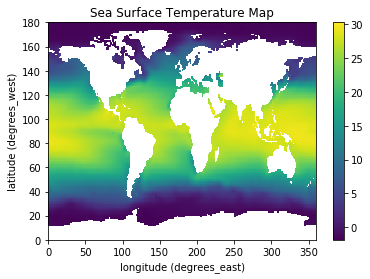

In [127]:
plt.pcolormesh( masked )
plt.colorbar();

plt.title('Sea Surface Temperature Map');
plt.xlabel('longitude (degrees_east)');
plt.ylabel('latitude (degrees_west)');

### Issues again with accessing attributes. Temporarily hardcoded in the names
# plt.title(tos.long_name);
# plt.xlabel('%s (%s)' %(lon.long_name, lon.units));
# plt.ylabel('%s (%s)' %(lat.long_name, lat.units));